Import packages

In [91]:
import re
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

Set global variables

In [92]:
OUTPUT_PATH = '../data/postprocessing/240123_compare_hp_operation/'

Read output data

In [93]:
output_wo_hp_df = pd.read_csv(OUTPUT_PATH + 'wo_hp_output_time_series.csv', index_col=0)
output_wi_hp_df = pd.read_csv(OUTPUT_PATH + 'wi_hp_output_time_series.csv', index_col=0)

Prepare class for Assets

In [94]:
class Assets:
    """Class for evaluating asset output data."""

    def __init__(self, input_data: pd.DataFrame) -> None:
        self.ids = []
        self.input_data = input_data
        self.asset_data = {}
        self.postprocess_data = {}
        self.objective_value = None

        self.get_asset_ids()
        self.get_asset_data()
        self.calc_postprocess_data()
        # self.get_objective_value_from_log()


    def get_asset_ids(self):
        """Get all unique asset names from the input data."""
        ids_set = set()

        for column_name in self.input_data.columns:
            if not '.' in column_name:
                continue
            key = re.sub('\..*$', '', column_name)      # Replace every character after a '.'.
            key = key.replace('_expanded', '')          # Replace additional characters.
            ids_set.add(key)                            # Remove duplicate keys.
        
        for id in ids_set:
            self.ids.append(id)
        
        self.ids.sort()

        if not self.ids:
            raise ValueError("""Found no asset ids in input data.""")


    def get_asset_data(self):
        """Get the specific asset data from the input data."""

        for id in self.ids:
            asset_df = pd.DataFrame()

            for column_name in self.input_data.columns:
                if id in column_name:
                    key_name = re.sub('^.*\.', '', column_name)
                    asset_df[key_name] = self.input_data[column_name]
            
            self.asset_data[id] = asset_df


    def calc_postprocess_data(self):
        """Calculates the sum of all columns in the asset data."""

        for key in self.asset_data:
            asset_dict = {}
            for column in self.asset_data[key].columns:
                column_sum = self.asset_data[key][column].sum()
                asset_dict[column] = column_sum
                self.postprocess_data[key] = asset_dict
    
    
    def get_objective_value_from_log(self):
        """Gets the objective value from the solver log file."""

        with open(OUTPUT_PATH + 'solver.log', 'r') as log_file:
            for line in log_file:
                if 'Best objective' in line:
                    line = line.replace('Best objective ', '')
                    line = re.sub(',.*$', '', line)
                    self.objective_value = round(float(line), 1)
                    

    def check_objective_value(self):
        """Calculates the objective value from the output data and checks if it is identical 
        to the solver results."""

        result = sum(
            self.asset_data['ngas_grid']['overall_ngas'] * self.input_data['gas_price'] +
            self.asset_data['electrical_grid']['overall_power'] * self.input_data['power_price'] +
            self.asset_data['hydrogen_grid']['overall_hydrogen'] * self.input_data['gas_price'] * 5.0
            )
        result = round(result, 1)
        
        if result == self.objective_value:
            print('\nObjective value and calculated value are the same.')
            print(f'{self.objective_value} == {result}')
        else:
            print('\nObjective value and calculated value are not identical!')
            print(f'{self.objective_value} =/= {result}')


Calculate overview data for assets

In [95]:
assets_wo = Assets(output_wo_hp_df)

df = pd.DataFrame(assets_wo.postprocess_data)
print(df)

                        arc1     arc2    arc3    arc4     arc5  battery_storage          chp  electrical_grid  electrolyzer     heatgrid  hydrogen_grid    ngas_grid       pv
power              3399.9118  1.73362  6236.7  6236.7  15797.4              NaN  3399.911800              NaN  1.579740e+04          NaN            NaN          NaN  1.73362
power_balance            NaN      NaN     NaN     NaN      NaN     1.136868e-12          NaN              NaN           NaN          NaN            NaN          NaN      NaN
charging_power           NaN      NaN     NaN     NaN      NaN     6.236700e+03          NaN              NaN           NaN          NaN            NaN          NaN      NaN
discharging_power        NaN      NaN     NaN     NaN      NaN     6.236700e+03          NaN              NaN           NaN          NaN            NaN          NaN      NaN
energy_content           NaN      NaN     NaN     NaN      NaN     7.335620e+04          NaN              NaN           NaN       

In [96]:
assets_wi = Assets(output_wi_hp_df)

df = pd.DataFrame(assets_wi.postprocess_data)
print(df)

                       arc01    arc02   arc03   arc04        arc05        arc12        arc13        arc14  battery_storage          chp  electrical_grid  electrolyzer      heatgrid     heatpump  hydrogen_grid    ngas_grid       pv
power              3399.9118  1.73362  5800.0  5800.0  7502.599656          NaN          NaN  2753.222344              NaN  3399.911800              NaN  7.502600e+03           NaN  2753.222344            NaN          NaN  1.73362
heat                     NaN      NaN     NaN     NaN          NaN  8259.667032  4533.215733          NaN              NaN  4533.215733              NaN  2.753222e+03           NaN          NaN            NaN          NaN      NaN
power_balance            NaN      NaN     NaN     NaN          NaN          NaN          NaN          NaN    -6.821210e-13          NaN              NaN           NaN           NaN          NaN            NaN          NaN      NaN
charging_power           NaN      NaN     NaN     NaN          NaN          

Plot runtime electrolyzer & chp

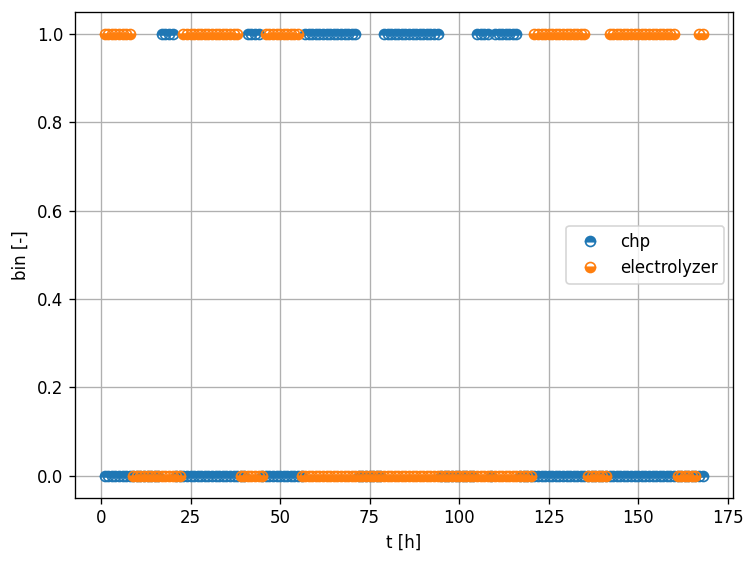

In [97]:
plt.figure(dpi=120)

assets_wi.asset_data['chp']['bin'].plot(style='o', fillstyle='top', label='chp')
assets_wi.asset_data['electrolyzer']['bin'].plot(style='o', fillstyle='bottom', label='electrolyzer')

plt.xlabel('t [h]')
plt.ylabel('bin [-]')
plt.grid()
plt.legend()
plt.tight_layout()

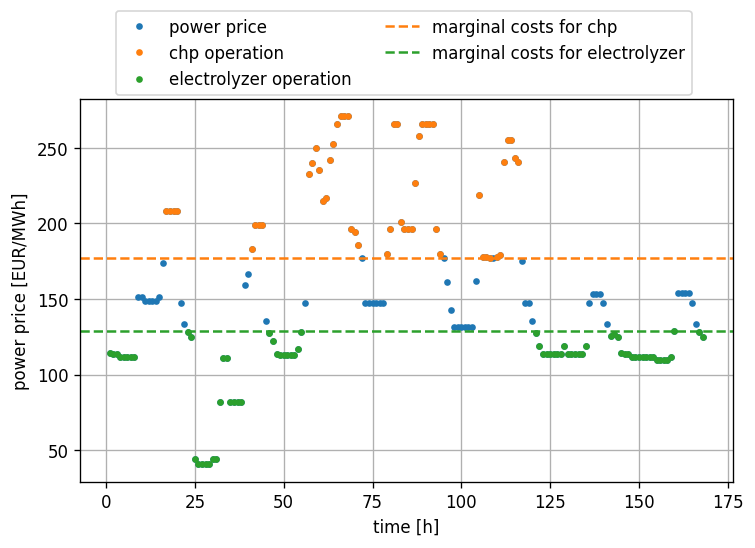

In [101]:
chp_working_prices = assets_wi.input_data['power_price'].where(assets_wi.asset_data['chp']['bin'] > 0)
electrolyzer_working_prices = assets_wi.input_data['power_price'].where(assets_wi.asset_data['electrolyzer']['bin'] > 0)

plt.figure(dpi=120)

assets_wi.input_data['power_price'].plot(style='.', label='power price')
chp_working_prices.plot(style='.', label='chp operation')
electrolyzer_working_prices.plot(style='.', label='electrolyzer operation')

plt.axhline(y=chp_working_prices.min(), linestyle='--', color='C1', label='marginal costs for chp')
plt.axhline(y=electrolyzer_working_prices.max(), linestyle='--', color='C2', label='marginal costs for electrolyzer')

plt.grid()

plt.ylabel('power price [EUR/MWh]')
plt.xlabel('time [h]')

plt.legend(ncols=2, bbox_to_anchor=(0.95, 1.25))
plt.tight_layout()

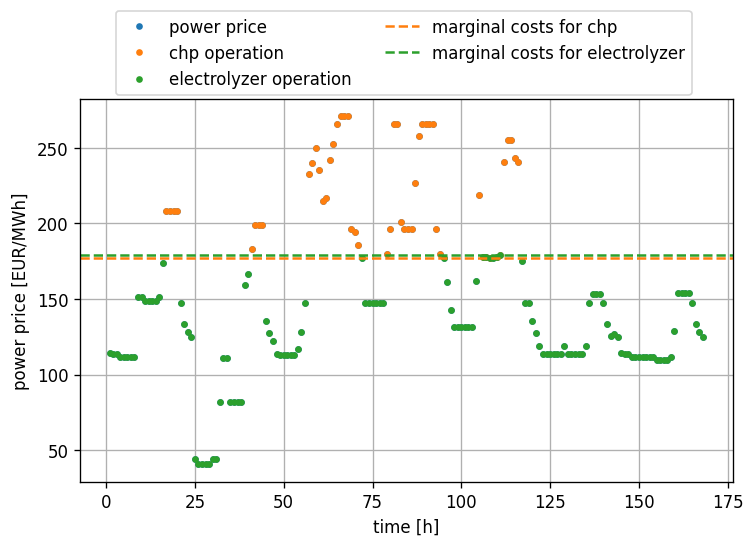

In [102]:
chp_working_prices = assets_wo.input_data['power_price'].where(assets_wo.asset_data['chp']['bin'] > 0)
electrolyzer_working_prices = assets_wo.input_data['power_price'].where(assets_wo.asset_data['electrolyzer']['bin'] > 0)

plt.figure(dpi=120)

assets_wo.input_data['power_price'].plot(style='.', label='power price')
chp_working_prices.plot(style='.', label='chp operation')
electrolyzer_working_prices.plot(style='.', label='electrolyzer operation')

plt.axhline(y=chp_working_prices.min(), linestyle='--', color='C1', label='marginal costs for chp')
plt.axhline(y=electrolyzer_working_prices.max(), linestyle='--', color='C2', label='marginal costs for electrolyzer')

plt.grid()

plt.ylabel('power price [EUR/MWh]')
plt.xlabel('time [h]')

plt.legend(ncols=2, bbox_to_anchor=(0.95, 1.25))
plt.tight_layout()

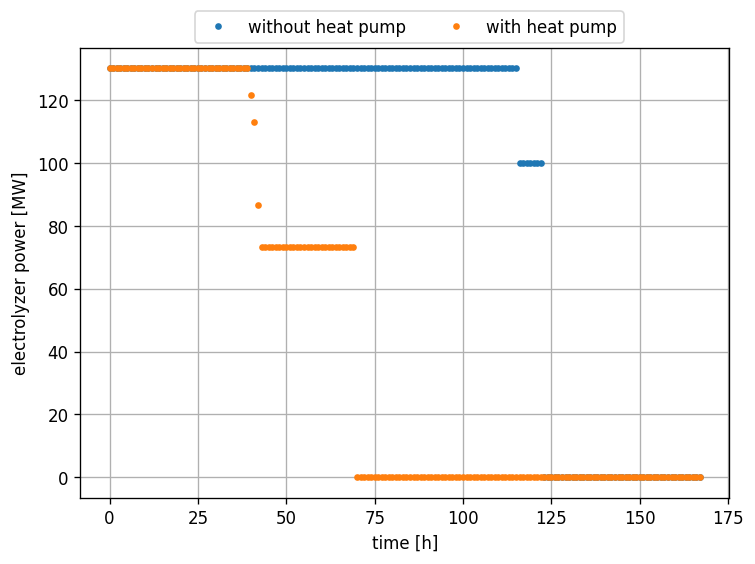

In [118]:
plt.figure(dpi=120)
assets_wo.asset_data['electrolyzer']['power'].sort_values(ascending=False, ignore_index=True).plot(label='without heat pump', style='.')
assets_wi.asset_data['electrolyzer']['power'].sort_values(ascending=False, ignore_index=True).plot(label='with heat pump', style='.')

plt.ylabel('electrolyzer power [MW]')
plt.xlabel('time [h]')
plt.grid()
plt.legend(ncols=2, bbox_to_anchor=(0.85, 1.1))
plt.tight_layout()